# contrasts_pond_core_properties

Notebook to injest ice core data from spreadsheets and compare bare ice and pond ice properties

@author: David Clemens-Sewall

In [103]:
import os
import glob
import re
import warnings
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
import seaborn as sns

from openpyxl import load_workbook
from matplotlib.colors import Normalize
from matplotlib.ticker import FixedFormatter

%matplotlib inline

In [182]:
# Paths
ic_data_root = os.path.join('..', 'data', 'ice_coring')

In [183]:
# Ice core data is very complicated, especially the vertical reference frame
# Define a class for representing ice cores
class IceCore:
    """
    Class representing data from an individual ice core.

    Attributes:
        station (str): Station number (1, 2, or 3) as a string.
        visit (str): Visit letter ([a-d]).
        file_path (str): Path to the xlsx file containing core data.
        core (str): Name of the core.
        site (str): Site name
        timestamp (datetime.datetime): Timestamp for the core.
        hi (float): Ice thickness (measured by a thickness gauge) in meters.
        draft (float): Draft (measured by a thickness gauge) in meters.
        length (float): Total core length in meters.
        freeboard (float): Freeboard (ice thickness - draft) in meters.
        snow_depths (array): Array of snow depths in meters.
        hs (float): Mean snow depth in meters.
        hp (float): Pond depth in meters.
        ponded (bool): Whether the ice was ponded.
        age (str): Sea ice age.
        data (Pandas.DataFrame): Dataframe containing data for this core.
        comments (Pandas.DataFrame): Dataframe containing comments for this core.
        units (dict): Mapping of variable names in self.data to units.
        variables (list): List of data variables that this ice core has.
    """
    
    def __init__(self, station, visit, file_path):
        """
        Initialize an IceCore object and load basic core metadata.

        Parameters:
            station (str): Station number (1, 2, or 3) as a string.
            visit (str): Visit letter ([a-d]).
            file_path (str): Path to the xlsx file containing core data.
        """
        # Store attributes
        self.station = station
        self.visit = visit
        self.file_path = file_path

        # Open excel workbook
        wb = load_workbook(file_path, read_only=True, data_only=True)
        ws_core = wb['metadata-core']
        ws_coring = wb['metadata-coring']

        # Get the core name from the workbook and check that it matches the filename
        core_fn = os.path.basename(file_path)[:-5]
        core_wb = ws_core['C1'].value
        if core_fn != core_wb:
            warnings.warn(f"Core name from filename does not match workbook, using core name from filename: {core_fn}",
                          category=RuntimeWarning)
        self.core = core_fn
        self.site = ws_coring['C4'].value

        ## Get basic parameters
        # time
        if ws_core['D2'].value == 'UTC':
            tzinfo = datetime.timezone.utc
        else:
            raise RuntimeError('Timezone is not UTC, need to implement support for other timezones')
        date = ws_core['C2'].value
        time = ws_core['C3'].value
        if time is None:
            time = ws_coring['C13'].value
        if time is None:
            warnings.warn(f"{core_fn} is missing time info setting to 12 utc")
            time = datetime.time(hour=12)
        self.timestamp = datetime.datetime.combine(date, time, tzinfo=tzinfo)
        # ice measurements
        self.hi = ws_core['C7'].value
        self.draft = ws_core['C8'].value
        self.freeboard = ws_core['C9'].value
        self.length = ws_core['C10'].value
        if self.length is None:
            raise RuntimeError(f"{self.core} is missing core length")
        # Account for potential missing core data
        if self.hi is None:
            warnings.warn(f"{self.core} is missing ice thickness, using core length",
                          category=RuntimeWarning)
            self.hi = self.length
        if (self.draft is None) and (self.freeboard is None):
            warnings.warn(f"{self.core} is missing freeboard and draft",
                         category=RuntimeWarning)
        elif self.freeboard is None:
            self.freeboard = self.hi - self.draft
        elif self.draft is None:
            self.draft = self.hi - self.freeboard
        self.age = ws_coring['C20'].value
        # snow measurements
        for value in ws_coring.iter_rows(min_row=16, max_row=16, min_col=3, max_col=8, values_only=True):
            self.snow_depths = np.array(value, dtype=float)
        if np.isnan(self.snow_depths).all():
            self.hs = 0
        else:
            self.hs = np.nanmean(self.snow_depths)
        # pond measurements
        self.hp = ws_coring['C19'].value
        if self.hp is None:
            self.ponded = False
            self.hp = 0
        else:
            self.ponded = True

        ## Initialize the data and comments dataframes
        idx = pd.MultiIndex.from_tuples([], names=('variable', 'depth_top', 'depth_bottom', 'depth_center'))
        self.data = pd.DataFrame(columns=['value'], index=idx)
        self.comments = pd.DataFrame(columns=['description', 'comment'], index=idx)
        self.units = {}
        self.variables = []
        wb.close()

    def load_salinity(self):
        """Loads salinity data if present in file."""

        # Get temperature sheet
        wb = load_workbook(self.file_path, read_only=True, data_only=True)
        ws = wb['SALO18']

        # If there is no data at all in the temperature sheet, return
        if ws['A5'].value is None:
            return
        # Read in values
        ls_d_t = []
        ls_d_b = []
        ls_s = []
        ls_c = []
        for row in ws.iter_rows(min_row=5, min_col=1, max_col=14):
            d_t = row[0].value
            if d_t is None:
                break
            else:
                ls_d_t.append(d_t)
                ls_d_b.append(row[1].value)
                ls_s.append(row[4].value)
                ls_c.append(row[13].value)
        # Create temporary dataframes and concatenate
        df_data_temp = pd.DataFrame({'variable': 'salinity',
                                     'depth_top': ls_d_t,
                                     'depth_bottom': ls_d_b,
                                     'depth_center': np.nan,
                                     'value': ls_s})
        df_data_temp['depth_center'] = (df_data_temp['depth_top'] + df_data_temp['depth_bottom'])/2.0
        df_data_temp.set_index(['variable', 'depth_top', 'depth_bottom', 'depth_center'],
                               inplace=True)
        df_comm_temp = pd.DataFrame({'variable': 'salinity',
                                     'depth_top': ls_d_t,
                                     'depth_bottom': ls_d_b,
                                     'depth_center': np.nan,
                                     'description': '',
                                     'comment': ls_c})
        df_comm_temp['depth_center'] = (df_comm_temp['depth_top'] + df_comm_temp['depth_bottom'])/2.0
        df_comm_temp.set_index(['variable', 'depth_top', 'depth_bottom', 'depth_center'],
                               inplace=True)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.data = pd.concat([self.data, df_data_temp])
            self.comments = pd.concat([self.comments, df_comm_temp])
        # Update variables and units fields
        self.variables.append('salinity')
        self.units['salinity'] = ws['E4'].value
        wb.close()

    def load_densimetry(self):
        """Loads densimetry data if present in file."""

        # Get temperature sheet
        wb = load_workbook(self.file_path, read_only=True, data_only=True)
        ws = wb['Density-densimetry']

        # If there is no data at all in the temperature sheet, return
        if ws['A4'].value is None:
            return
        # Read in values
        ls_d_t = []
        ls_d_b = []
        ls_r = []
        ls_c = []
        for row in ws.iter_rows(min_row=4, min_col=1, max_col=8):
            d_t = row[0].value
            if d_t is None:
                break
            else:
                ls_d_t.append(d_t)
                ls_d_b.append(row[1].value)
                ls_r.append(row[6].value)
                ls_c.append(row[7].value)
        # Create temporary dataframes and concatenate
        df_data_temp = pd.DataFrame({'variable': 'density',
                                     'depth_top': ls_d_t,
                                     'depth_bottom': ls_d_b,
                                     'depth_center': np.nan,
                                     'value': ls_r})
        df_data_temp['depth_center'] = (df_data_temp['depth_top'] + df_data_temp['depth_bottom'])/2.0
        df_data_temp.set_index(['variable', 'depth_top', 'depth_bottom', 'depth_center'],
                               inplace=True)
        df_comm_temp = pd.DataFrame({'variable': 'density',
                                     'depth_top': ls_d_t,
                                     'depth_bottom': ls_d_b,
                                     'depth_center': np.nan,
                                     'description': '',
                                     'comment': ls_c})
        df_comm_temp['depth_center'] = (df_comm_temp['depth_top'] + df_comm_temp['depth_bottom'])/2.0
        df_comm_temp.set_index(['variable', 'depth_top', 'depth_bottom', 'depth_center'],
                               inplace=True)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.data = pd.concat([self.data, df_data_temp])
            self.comments = pd.concat([self.comments, df_comm_temp])
        # Update variables and units fields
        self.variables.append('density')
        self.units['density'] = ws['G3'].value
        wb.close()

    def load_temperature(self):
        """Loads temperature data if present in file."""

        # Get temperature sheet
        wb = load_workbook(self.file_path, read_only=True, data_only=True)
        ws = wb['TEMP']

        # If there is no data at all in the temperature sheet, return
        if ws['A4'].value is None:
            return
        # Read in values
        ls_d_c = []
        ls_t = []
        ls_c = []
        for row in ws.iter_rows(min_row=4, min_col=1, max_col=3):
            d_c = row[0].value
            if d_c is None:
                break
            else:
                ls_d_c.append(d_c)
                ls_t.append(row[1].value)
                ls_c.append(row[2].value)
        # Create temporary dataframes and concatenate
        df_data_temp = pd.DataFrame({'variable': 'temperature',
                                     'depth_top': np.nan,
                                     'depth_bottom': np.nan,
                                     'depth_center': ls_d_c,
                                     'value': ls_t})
        df_data_temp.set_index(['variable', 'depth_top', 'depth_bottom', 'depth_center'],
                               inplace=True)
        df_comm_temp = pd.DataFrame({'variable': 'temperature',
                                     'depth_top': np.nan,
                                     'depth_bottom': np.nan,
                                     'depth_center': ls_d_c,
                                     'description': '',
                                     'comment': ls_c})
        df_comm_temp.set_index(['variable', 'depth_top', 'depth_bottom', 'depth_center'],
                               inplace=True)
        self.data = pd.concat([self.data, df_data_temp])
        self.comments = pd.concat([self.comments, df_comm_temp])
        # Update variables and units fields
        self.variables.append('temperature')
        self.units['temperature'] = ws['B3'].value
        wb.close()

    def plot_profile(self, ax, variable, z_ref='ice top', z_scale='absolute',
                     kind='center', linestyle='solid', color = 'C0',
                    markersize=3):
        """
        Plots a profile of a single variable from the ice core following various conventions

        Parameters:
            ax (Matplotlib Axes): Axes to plot on.
            variable (str): Variable to plot, must be in self.data
            z_ref (str): Vertical reference for profile, must be one of ['ice top',
                'sea surface', 'pond surface']. The default is 'ice top'.
            z_scale (str): How to scale z values, must be one of ['absolute', 
                'relative']. The default is 'absolute'.
            kind (str): Whether to plot values at the 'center' of ice segments
                or as a line spanning entire segment ('segment') the default is 'center'.
            linestyle (str): Line style for line.
            color (color for Matplotlib): Line color.
            markersize (float): Marker size

        Returns:
            Handle from matplotlib object.
        """
        
        # z_ref_dict for converting z_ref into z values
        z_ref_dict = {'ice top': 0,
                      'sea surface': self.freeboard,
                      'pond surface': -self.hp
                     }
        z_unit_dict = {'absolute': 'm',
                       'relative': '1',
                      }
        # Get data
        df_plot = self.data.query('variable == @variable').reset_index()
        # Adjust for z-reference
        df_plot['z_t'] = z_ref_dict[z_ref] - df_plot['depth_top']
        df_plot['z_b'] = z_ref_dict[z_ref] - df_plot['depth_bottom']
        df_plot['z_c'] = z_ref_dict[z_ref] - df_plot['depth_center']
        # If scale is relative, adjust for relative vertical position
        if z_scale == 'relative':
            if z_ref == 'pond surface':
                z_top = 0
                z_bottom = -self.hp - self.length
            else:
                z_top = z_ref_dict[z_ref]
                z_bottom = z_top - self.length
            df_plot['z_t'] = (df_plot['z_t'] - z_bottom) / (z_top - z_bottom)
            df_plot['z_b'] = (df_plot['z_b'] - z_bottom) / (z_top - z_bottom)
            df_plot['z_c'] = (df_plot['z_c'] - z_bottom) / (z_top - z_bottom)
        elif z_scale != 'absolute':
            raise RuntimeError('invalid value for z_scale')
        
        # Plot values
        if kind == 'segment':
            h = ax.vlines(df_plot['value'], df_plot['z_b'], df_plot['z_t'],
                      colors=color, linestyles=linestyle, label=self.core)
            ax.plot(df_plot['value'], df_plot['z_b'], color=color,
                    marker='o', linestyle='none', label=None,
                   markersize=markersize)
            ax.plot(df_plot['value'], df_plot['z_t'], color=color,
                    marker='o', linestyle='none', label=None,
                   markersize=markersize)
        elif kind == 'center':
            h = ax.plot(df_plot['value'], df_plot['z_c'],
                        color=color, linestyle=linestyle, label=self.core,
                        marker='o', markersize=markersize)
        else:
            raise RuntimeError('invalid value for kind')

        ax.set_ylabel(f'{z_scale} height from {z_ref} ({z_unit_dict[z_scale]})')
        ax.set_xlabel(f'{variable} ({self.units[variable]})')

        return h

    def bulk_property(self, variable):
        """
        Return the bulk (vertically-averaged) property.

        Paramters:
            variable (str): Variable name to compute bulk property.

        Returns:
            (float) bulk property.
        """

        if not variable in self.units:
            raise RuntimeError(f'{variable} not found in {self.core}')

        df_temp = self.data.query('variable == @variable').reset_index()
        df_temp['thickness'] = df_temp.depth_bottom - df_temp.depth_top
        
        return (df_temp['value']*df_temp['thickness']).sum()/df_temp['thickness'].sum()

    def total_salt(self, density=None, phi_connected=0):
        """
        Return the total amount of salk (kg/m2) in the ice column.

        Parameters:
            density (float): Disconnected ice density (g/cm3). If None,
                use density data from the core. The default is None.
            phi_connected (float): The volume fraction of the ice that is
                fully connected to the ocean, and hence unmeasured in a core
                and not part of the ice itself. The default is 0.

        Returns:
            (float) Total mass of salt in ice column (kg/m2)
        """

        # Check data is present
        if not 'salinity' in self.units:
            raise RuntimeError(f'{self.core} does not have salinity data')
        if (density is None) and (not 'density' in self.units):
            raise RuntimeError(f'{self.core} does not have requested density data')

        # Create dataframe for calculation
        if density is None:
            df_temp = self.data.query('variable in ["salinity", "density"]').reset_index(
                'variable').pivot(columns='variable', values='value')
            if df_temp.isnull().values.any():
                raise NotImplementedError(f'mismatched or missing density and salinity in {core}')
        else:
            df_temp = self.data.query('variable == "salinity"').reset_index(
                'variable', drop=True).rename(columns={'value': 'salinity'})
            df_temp['density'] = density
        df_temp = df_temp.reset_index()
        df_temp['thickness'] = df_temp.depth_bottom - df_temp.depth_top

        # Return value
        # [density] g/cm3 * 1kg/1e3g * 1e6cm3/1m3 * [thickness] m * [salinity] g/kg * 1kg/1e3g * [1 - phi_connected]
        return (df_temp.density*df_temp.thickness*df_temp.salinity*(1 - phi_connected)).sum()

In [184]:
# MOSAiC data is formatted very differently. Let's define a subclass to simplify loading these data.
class MosaicCore(IceCore):
    """
    Provides the same functionality as IceCore, but different methods for loading data
    """

    def __init__(self, station, visit, file_path):
        """
        Initialize a MosaicCore object and load basic core metadata.

        Parameters:
            station (str): Station ['MOSAiC_FYI', 'MOSAiC_SYI'].
            visit (str): Event string as visit.
            file_path (str): Path to the file containing core data.
        """

        # Store attributes
        self.station = station
        self.visit = visit
        self.file_path = file_path

        ## Open file with all cores as dataframe
        with open(file_path) as f:
            for i, line in enumerate(f):
                if line == '*/\n':
                    break
        skiprows = i + 1
        df_mosaic = pd.read_table(file_path, skiprows=skiprows)
        df_mosaic = df_mosaic[df_mosaic.Event == visit]
        
        # Set the core name as the event, site is same as station
        self.core = visit
        self.site = station

        ## Get basic parameters
        cols = ['Event', 
                'Date/Time', 
                'Sea ice draft [m] (Distance from water level to ...)',
                'Core length [m] (Total length of the extracted...)',
                'Snow h [m] (Average snow depth at coring ...)',
               ]
        df_mosaic = df_mosaic[cols].drop_duplicates(ignore_index=True)
        if df_mosaic.shape[0] != 1:
            raise RuntimeError(f'Non-unique basic parameters in {visit}')
        # time
        self.timestamp = datetime.datetime.fromisoformat(df_mosaic.at[0, 'Date/Time'] + '+00:00')
        # ice measurements
        self.hi = df_mosaic.at[0, 'Core length [m] (Total length of the extracted...)']
        self.draft = df_mosaic.at[0, 'Sea ice draft [m] (Distance from water level to ...)']
        self.length = df_mosaic.at[0, 'Core length [m] (Total length of the extracted...)']
        self.freeboard = self.hi - self.draft
        if station[-3:] == 'FYI':
            self.age = 'FY (first year)'
        elif station[-3:] == 'SYI':
            self.age = 'SY (first year)'
        else:
            raise RuntimeError(f'Unrecognized age in {station}')
        # snow measurements
        self.hs = df_mosaic.at[0, 'Snow h [m] (Average snow depth at coring ...)']
        # pond measurements
        self.hp = 0
        self.ponded = False

        ## Initialize the data and comments dataframes
        idx = pd.MultiIndex.from_tuples([], names=('variable', 'depth_top', 'depth_bottom', 'depth_center'))
        self.data = pd.DataFrame(columns=['value'], index=idx)
        self.comments = pd.DataFrame(columns=['description', 'comment'], index=idx)
        self.units = {}
        self.variables = []

    def load_salinity(self):
        """Loads salinity data if present in file."""

        # Get core dataframe
        with open(self.file_path) as f:
            for i, line in enumerate(f):
                if line == '*/\n':
                    break
        skiprows = i + 1
        df_mosaic = pd.read_table(self.file_path, skiprows=skiprows)
        df_mosaic = df_mosaic[df_mosaic.Event == self.visit]

        # Create dataframes formatted as expected by IceCore
        df_data_temp = pd.DataFrame({'variable': 'salinity',
                                     'depth_top': -1*df_mosaic['Depth ice/snow top [m] (top of ice layer sampled, mea...)'],
                                     'depth_bottom': -1*df_mosaic['Depth ice/snow bot [m] (bottom of ice layer sampled, ...)'],
                                     'depth_center': np.nan,
                                     'value': df_mosaic['Sea ice sal (Practical salinity measured a...)'],})
        df_data_temp['depth_center'] = (df_data_temp['depth_top'] + df_data_temp['depth_bottom'])/2.0
        df_data_temp.set_index(['variable', 'depth_top', 'depth_bottom', 'depth_center'],
                               inplace=True)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.data = pd.concat([self.data, df_data_temp])
        # Update variables and units fields
        self.variables.append('salinity')
        self.units['salinity'] = '‰' # hack because CONTRASTS uses ppt, not PSU

    def load_density(self):
        """Loads density data if present in file."""

        # Get core dataframe
        with open(self.file_path) as f:
            for i, line in enumerate(f):
                if line == '*/\n':
                    break
        skiprows = i + 1
        df_mosaic = pd.read_table(self.file_path, skiprows=skiprows)
        df_mosaic = df_mosaic[df_mosaic.Event == self.visit]

        # Create dataframes formatted as expected by IceCore
        df_data_temp = pd.DataFrame({'variable': 'density',
                                     'depth_top': -1*df_mosaic['Depth ice/snow top [m] (top of ice layer sampled, mea...)'],
                                     'depth_bottom': -1*df_mosaic['Depth ice/snow bot [m] (bottom of ice layer sampled, ...)'],
                                     'depth_center': np.nan,
                                     'value': 1e-3 * df_mosaic['Density ice [kg/m**3] (prime; Sea ice density measur...)'],})
        df_data_temp['depth_center'] = (df_data_temp['depth_top'] + df_data_temp['depth_bottom'])/2.0
        df_data_temp.set_index(['variable', 'depth_top', 'depth_bottom', 'depth_center'],
                               inplace=True)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.data = pd.concat([self.data, df_data_temp])
        # Update variables and units fields
        self.variables.append('density')
        self.units['density'] = 'g / cm3' # hack because CONTRASTS uses g/cm3

In [185]:
# Load all ice core data
stations = ['1', '2', '3']
visits = ['a', 'b', 'c', 'd']

# Load each core into a dataframe
ls_s = []
ls_v = []
ls_name = []
ls_icecore = []
for station in stations:
    for visit in visits:
        filepaths = glob.glob(os.path.join(ic_data_root, f"IceStation{station}{visit}", '**', '[!~]*.xlsx'))
        for fp in filepaths:
            if os.path.basename(fp)[:3] == 'Ice':
                continue
            # load core properties
            try:
                ic = IceCore(station, visit, fp)
            except RuntimeError as err:
                print(err)
                continue
            # Load data if present
            ic.load_temperature()
            ic.load_salinity()
            ic.load_densimetry()
            # Append to lists
            ls_s.append(station)
            ls_v.append(visit)
            ls_name.append(ic.core)
            ls_icecore.append(ic)

df_cores = pd.DataFrame({'station': ls_s,
                         'visit': ls_v,
                         'name': ls_name,
                         'core': ls_icecore})
df_cores = df_cores.set_index(['station', 'visit', 'name'])

df_cores['timestamp'] = datetime.datetime(2025, 1, 1, tzinfo=datetime.timezone.utc)
for i in np.arange(df_cores.shape[0]):
    df_cores.iat[i,1] = df_cores.iat[i,0].timestamp

/tmp/ipykernel_31965/1002622467.py:52: RuntimeWarning: Core name from filename does not match workbook, using core name from filename: 20250710-PS149_13-1-SI_corer_9cm-016-FYI-REP
  warnings.warn(f"Core name from filename does not match workbook, using core name from filename: {core_fn}",
/tmp/ipykernel_31965/1002622467.py:254: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, df_data_temp])
/tmp/ipykernel_31965/1002622467.py:52: RuntimeWarning: Core name from filename does not match workbook, using core name from filename: 20250710-PS149_13-1-SI_corer_9cm-017-FYI-RHO
  warnings.warn(f"Core name from filename does not match workbook, using core name from filename: {core_fn}",
/tmp/ipykernel_31965/1002622467.py:

20250715-PS149_16-1-SI_corer_9cm-018-FYI-REP is missing core length


/tmp/ipykernel_31965/1002622467.py:254: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, df_data_temp])
/tmp/ipykernel_31965/1002622467.py:80: RuntimeWarning: 20250730-PS149_25-1-SI_corer_9cm-020-SMYI-T is missing ice thickness, using core length
  warnings.warn(f"{self.core} is missing ice thickness, using core length",
/tmp/ipykernel_31965/1002622467.py:84: RuntimeWarning: 20250730-PS149_25-1-SI_corer_9cm-020-SMYI-T is missing freeboard and draft
  warnings.warn(f"{self.core} is missing freeboard and draft",
/tmp/ipykernel_31965/1002622467.py:254: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA

In [187]:
# Paths
mos_data_root = os.path.join('..', '..', 'mosaic', 'data')
mos_fyi_filename = 'MOSAiC_MCS_FYI_sea_ice_nutrients.tab'
mos_syi_filename = 'MOSAiC_MCS_SYI_sea_ice_nutrients.tab'

mos_fyi_filepath = os.path.join(mos_data_root, mos_fyi_filename)
mos_syi_filepath = os.path.join(mos_data_root, mos_syi_filename)

df_mos_fyi = pd.read_table(mos_fyi_filepath, skiprows=101)
df_mos_syi = pd.read_table(mos_syi_filepath, skiprows=98)

# Load FYI
station = 'MOSAiC_FYI'
fyi_visits = np.unique(df_mos_fyi.Event)
ls_icecore = []
for visit in fyi_visits:
    ic = MosaicCore(station, visit, mos_fyi_filepath)
    ic.load_salinity()
    ic.load_density()
    ls_icecore.append(ic)
df_cores_fyi = pd.DataFrame({'station': station,
                                'visit': fyi_visits,
                                'core': ls_icecore,
                               })
# Load SYI
station = 'MOSAiC_SYI'
syi_visits = np.unique(df_mos_syi.Event)
ls_icecore = []
for visit in syi_visits:
    ic = MosaicCore(station, visit, mos_syi_filepath)
    ic.load_salinity()
    ic.load_density()
    ls_icecore.append(ic)

df_cores_syi = pd.DataFrame({'station': station,
                                'visit': syi_visits,
                                'core': ls_icecore,
                               })
df_cores_mosaic = pd.concat([df_cores_fyi, df_cores_syi])

df_cores_mosaic = df_cores_mosaic.set_index(['station', 'visit'])
df_cores_mosaic['timestamp'] = datetime.datetime(2025, 1, 1, tzinfo=timezone.utc)
for i in np.arange(df_cores_mosaic.shape[0]):
    df_cores_mosaic.iat[i,1] = df_cores_mosaic.iat[i,0].timestamp

In [188]:
df_cores_mosaic

core  \
station    visit                                                            
MOSAiC_FYI PS122/1_10-19   <__main__.MosaicCore object at 0x7f681dab5fd0>   
           PS122/1_5-3     <__main__.MosaicCore object at 0x7f681d35dee0>   
           PS122/1_6-34    <__main__.MosaicCore object at 0x7f681ea5a210>   
           PS122/1_7-6     <__main__.MosaicCore object at 0x7f681dbc86b0>   
           PS122/1_7-97    <__main__.MosaicCore object at 0x7f6813adc5f0>   
           PS122/1_8-2     <__main__.MosaicCore object at 0x7f681820f590>   
           PS122/1_9-6     <__main__.MosaicCore object at 0x7f681dbcaff0>   
           PS122/1_9-93    <__main__.MosaicCore object at 0x7f68135b0bc0>   
           PS122/2_17-3    <__main__.MosaicCore object at 0x7f6812e97290>   
           PS122/2_19-7    <__main__.MosaicCore object at 0x7f6813b31010>   
           PS122/2_21-13   <__main__.MosaicCore object at 0x7f681eb82a80>   
           PS122/2_23-3    <__main__.MosaicCore object at 0x7f681d62a780>   
           PS122/2_24-8    <__main__.MosaicCore object at 0x7f6813adf590>   
           PS122/3_32-63   <__main__.MosaicCore object at 0x7f6813b30ef0>   
           PS122/3_35-11   <__main__.MosaicCore object at 0x7f6813f94950>   
           PS122/3_36-21   <__main__.MosaicCore object at 0x7f6813e301d0>   
           PS122/3_38-24   <__main__.MosaicCore object at 0x7f681d62b830>   
           PS122/3_39-7    <__main__.MosaicCore object at 0x7f6812e95ca0>   
           PS122/4_44-134  <__main__.MosaicCore object at 0x7f681d628440>   
           PS122/4_46-18   <__main__.MosaicCore object at 0x7f6813ad2ed0>   
           PS122/4_47-16   <__main__.MosaicCore object at 0x7f681ecfbe90>   
           PS122/4_48-23   <__main__.MosaicCore object at 0x7f68135cd700>   
           PS122/4_49-34   <__main__.MosaicCore object at 0x7f681334d1f0>   
MOSAiC_SYI PS122/1_10-16   <__main__.MosaicCore object at 0x7f6822c17380>   
           PS122/1_5-78    <__main__.MosaicCore object at 0x7f681dd57050>   
           PS122/1_6-36    <__main__.MosaicCore object at 0x7f6813bc6000>   
           PS122/1_7-53    <__main__.MosaicCore object at 0x7f681eb833b0>   
           PS122/1_7-9     <__main__.MosaicCore object at 0x7f6813adc590>   
           PS122/1_9-11    <__main__.MosaicCore object at 0x7f6813e6edb0>   
           PS122/2_20-5    <__main__.MosaicCore object at 0x7f6813b6da30>   
           PS122/2_22-7    <__main__.MosaicCore object at 0x7f6813145d60>   
           PS122/2_25-15   <__main__.MosaicCore object at 0x7f6813b6df10>   
           PS122/3_33-18   <__main__.MosaicCore object at 0x7f681d92cd70>   
           PS122/3_35-4    <__main__.MosaicCore object at 0x7f68135faf90>   
           PS122/3_36-4    <__main__.MosaicCore object at 0x7f681ddaf230>   
           PS122/3_38-16   <__main__.MosaicCore object at 0x7f6813ef8f50>   
           PS122/3_39-18   <__main__.MosaicCore object at 0x7f681eac5460>   
           PS122/4_45-29   <__main__.MosaicCore object at 0x7f6813843590>   
           PS122/4_46-20   <__main__.MosaicCore object at 0x7f681334de50>   
           PS122/4_47-18   <__main__.MosaicCore object at 0x7f681354cf20>   
           PS122/4_48-25   <__main__.MosaicCore object at 0x7f681d9e6ba0>   

                                          timestamp  
station    visit                                     
MOSAiC_FYI PS122/1_10-19  2019-12-02 05:31:00+00:00  
           PS122/1_5-3    2019-10-27 23:46:00+00:00  
           PS122/1_6-34   2019-11-04 01:36:00+00:00  
           PS122/1_7-6    2019-11-11 03:00:00+00:00  
           PS122/1_7-97   2019-11-18 02:48:00+00:00  
           PS122/1_8-2    2019-11-18 08:10:00+00:00  
           PS122/1_9-6    2019-11-25 04:50:00+00:00  
           PS122/1_9-93   2019-11-30 10:57:00+00:00  
           PS122/2_17-3   2019-12-23 10:42:00+00:00  
           PS122/2_19-7   2020-01-06 08:43:00+00:00  
           PS122/2_21-13  2020-01-20 07:44:00+00:00  
           PS122/2_23-3   2020-02-03 07:45:00+00:00  
 

/tmp/ipykernel_31965/1724322185.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(pallette)


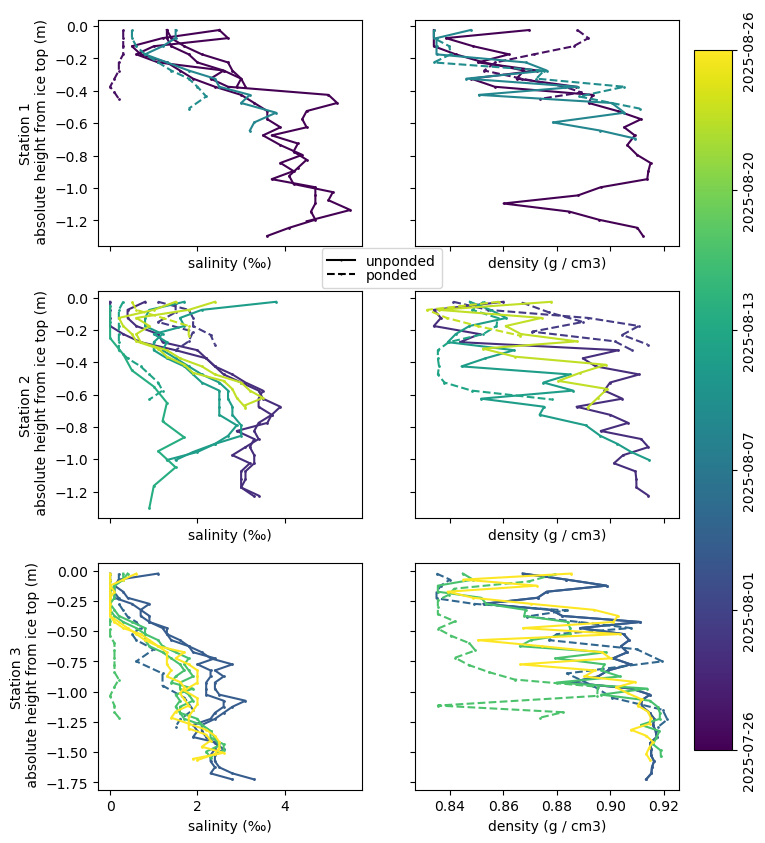

In [135]:
# Plot all salinities and densities
f, axs = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(7.5, 10))

stations = ['1', '2', '3']
visits = ['b', 'c', 'd']

z_ref = 'ice top'
z_scale = 'absolute'
pallette = 'viridis'
kind = 'center'
markersize = 1

cmap = cm.get_cmap(pallette)
min_time = df_cores.query('visit in @visits').timestamp.min()
max_time = df_cores.query('visit in @visits').timestamp.max()

for i, station in enumerate(stations):
    df_temp = df_cores.query('station == @station & visit in @visits').reset_index()
    for tup in df_temp.itertuples():
        if tup[3] == '20250730-PS149_25-1-SI_corer_9cm-021-SMYI-RHO':
            continue # input is missing draft and freeboard, skip for now
        
        visit = tup[2]
        ic = tup[4]
        if ic.ponded:
            ls = 'dashed'
        else:
            ls = 'solid'
        color = cmap((tup[5] - min_time)/(max_time - min_time))
        if 'salinity' in ic.units:
            #print(tup[3])
            ic.plot_profile(axs[i,0], 'salinity', z_ref=z_ref,
                            z_scale=z_scale,
                            color=color, linestyle=ls,
                           kind=kind, markersize=markersize)
        if 'density' in ic.units:
            #print(tup[3])
            ic.plot_profile(axs[i,1], 'density', z_ref=z_ref,
                            z_scale=z_scale,
                            color=color, linestyle=ls,
                           kind=kind, markersize=markersize)
    # Update ylabel
    ylbl = axs[i,0].get_ylabel()
    axs[i,0].set_ylabel(f'Station {station}\n {ylbl}')
    axs[i,1].set_ylabel('')

# Add colorbar
nticks = 6
f.subplots_adjust(right=0.9)
cbar_ax = f.add_axes([0.92, 0.15, 0.05, 0.7])
ticks = np.linspace(0, 1, nticks)
tick_labels = pd.date_range(start=min_time, end=max_time, periods=nticks
                           ).strftime('%Y-%m-%d').to_numpy()
norm = Normalize(vmin=0, vmax=1)
f.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
           cax=cbar_ax, orientation='vertical',
          ticks=ticks, aspect=80, shrink=0.5)
cbar_ax.set_yticklabels(tick_labels, rotation=90, va="center")

# Add legend
solid_line = mlines.Line2D([], [], color = 'k', marker='.',
                           markersize=markersize, label='unponded')
dashed_line = mlines.Line2D([], [], color = 'k', marker='.', linestyle='dashed',
                           markersize=markersize, label='ponded')
axs[0,0].legend(handles=[solid_line, dashed_line], bbox_to_anchor=(1.3, -0.01),
                borderaxespad=0., labelspacing=0.0)
plt.show()
f.savefig(os.path.join('..', 'figures', 
    f'contrasts_pond_sal_dens_{z_ref.replace(' ', '-')}_{z_scale}_{kind}.png'),
          bbox_inches='tight')

/tmp/ipykernel_31965/2355371094.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(pallette)


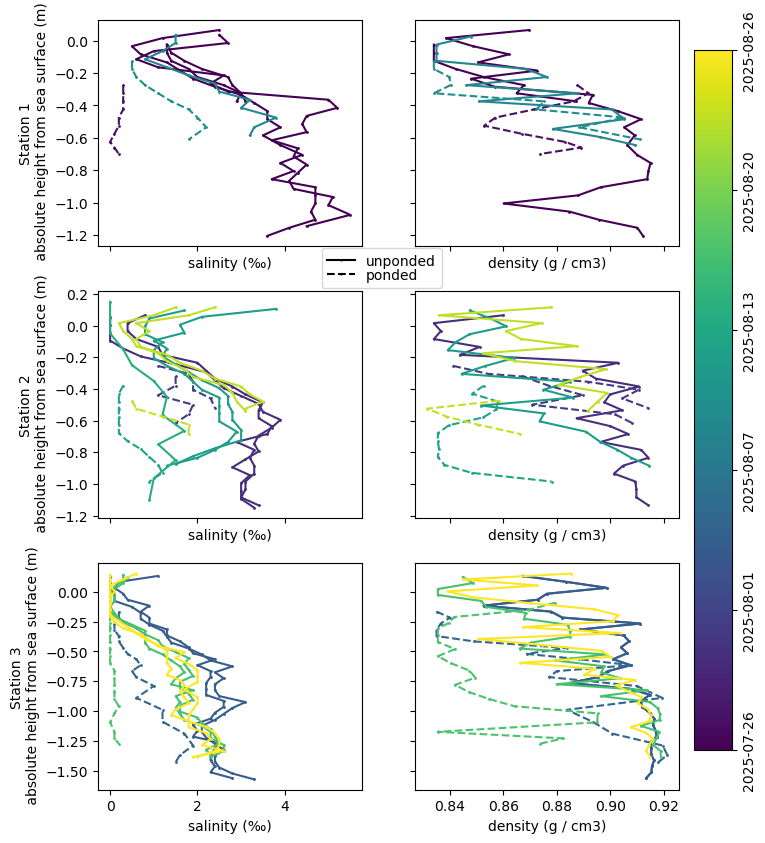

In [136]:
# Plot all salinities and densities
f, axs = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(7.5, 10))

stations = ['1', '2', '3']

z_ref = 'sea surface'
z_scale = 'absolute'
pallette = 'viridis'
kind = 'center'
markersize = 1

cmap = cm.get_cmap(pallette)
min_time = df_cores.query('visit in @visits').timestamp.min()
max_time = df_cores.query('visit in @visits').timestamp.max()

for i, station in enumerate(stations):
    df_temp = df_cores.query('station == @station & visit in @visits').reset_index()
    for tup in df_temp.itertuples():
        if tup[3] == '20250730-PS149_25-1-SI_corer_9cm-021-SMYI-RHO':
            continue # input is missing draft and freeboard, skip for now
        
        visit = tup[2]
        ic = tup[4]
        if ic.ponded:
            ls = 'dashed'
        else:
            ls = 'solid'
        color = cmap((tup[5] - min_time)/(max_time - min_time))
        if 'salinity' in ic.units:
            #print(tup[3])
            ic.plot_profile(axs[i,0], 'salinity', z_ref=z_ref,
                            z_scale=z_scale,
                            color=color, linestyle=ls,
                           kind=kind, markersize=markersize)
        if 'density' in ic.units:
            #print(tup[3])
            ic.plot_profile(axs[i,1], 'density', z_ref=z_ref,
                            z_scale=z_scale,
                            color=color, linestyle=ls,
                           kind=kind, markersize=markersize)
    # Update ylabel
    ylbl = axs[i,0].get_ylabel()
    axs[i,0].set_ylabel(f'Station {station}\n {ylbl}')
    axs[i,1].set_ylabel('')

# Add colorbar
nticks = 6
f.subplots_adjust(right=0.9)
cbar_ax = f.add_axes([0.92, 0.15, 0.05, 0.7])
ticks = np.linspace(0, 1, nticks)
tick_labels = pd.date_range(start=min_time, end=max_time, periods=nticks
                           ).strftime('%Y-%m-%d').to_numpy()
norm = Normalize(vmin=0, vmax=1)
f.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
           cax=cbar_ax, orientation='vertical',
          ticks=ticks, aspect=80, shrink=0.5)
cbar_ax.set_yticklabels(tick_labels, rotation=90, va="center")

# Add legend
solid_line = mlines.Line2D([], [], color = 'k', marker='.',
                           markersize=markersize, label='unponded')
dashed_line = mlines.Line2D([], [], color = 'k', marker='.', linestyle='dashed',
                           markersize=markersize, label='ponded')
axs[0,0].legend(handles=[solid_line, dashed_line], bbox_to_anchor=(1.3, -0.01),
                borderaxespad=0., labelspacing=0.0)
plt.show()

f.savefig(os.path.join('..', 'figures', 
    f'contrasts_pond_sal_dens_{z_ref.replace(' ', '-')}_{z_scale}_{kind}.png'),
          bbox_inches='tight')

/tmp/ipykernel_31965/1803587143.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(pallette)


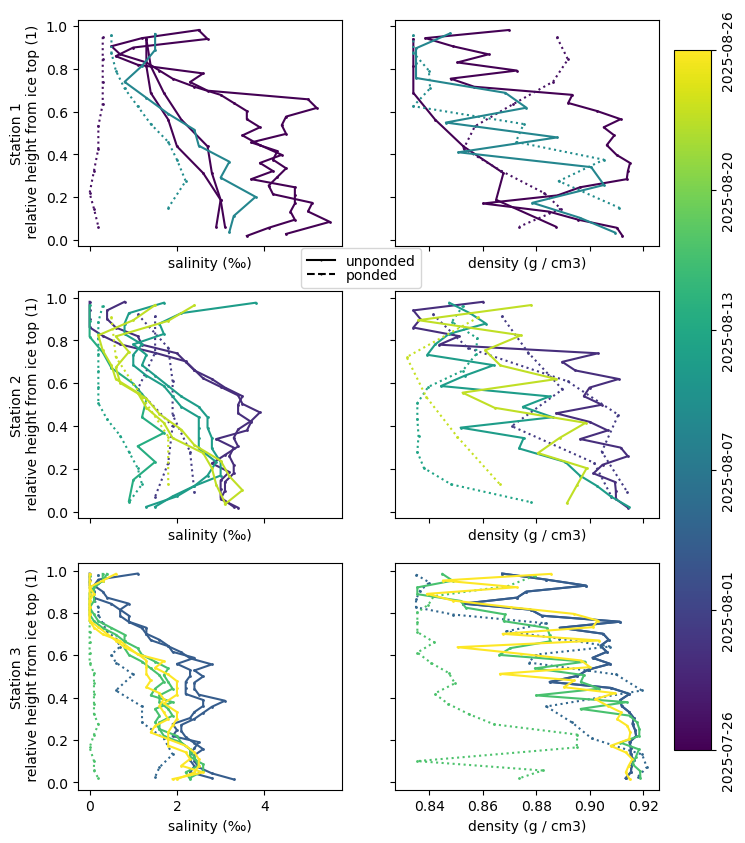

In [137]:
# Plot all salinities and densities
f, axs = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(7.5, 10))

stations = ['1', '2', '3']

z_ref = 'ice top'
z_scale = 'relative'
pallette = 'viridis'
kind = 'center'
markersize = 1

cmap = cm.get_cmap(pallette)
min_time = df_cores.query('visit in @visits').timestamp.min()
max_time = df_cores.query('visit in @visits').timestamp.max()

for i, station in enumerate(stations):
    df_temp = df_cores.query('station == @station & visit in @visits').reset_index()
    for tup in df_temp.itertuples():
        if tup[3] == '20250730-PS149_25-1-SI_corer_9cm-021-SMYI-RHO':
            continue # input is missing draft and freeboard, skip for now
        
        visit = tup[2]
        ic = tup[4]
        if ic.ponded:
            ls = 'dotted'
        else:
            ls = 'solid'
        color = cmap((tup[5] - min_time)/(max_time - min_time))
        if 'salinity' in ic.units:
            #print(tup[3])
            ic.plot_profile(axs[i,0], 'salinity', z_ref=z_ref,
                            z_scale=z_scale,
                            color=color, linestyle=ls,
                           kind=kind, markersize=markersize)
        if 'density' in ic.units:
            #print(tup[3])
            ic.plot_profile(axs[i,1], 'density', z_ref=z_ref,
                            z_scale=z_scale,
                            color=color, linestyle=ls,
                           kind=kind, markersize=markersize)
    # Update ylabel
    ylbl = axs[i,0].get_ylabel()
    axs[i,0].set_ylabel(f'Station {station}\n {ylbl}')
    axs[i,1].set_ylabel('')

# Add colorbar
nticks = 6
f.subplots_adjust(right=0.9)
cbar_ax = f.add_axes([0.92, 0.15, 0.05, 0.7])
ticks = np.linspace(0, 1, nticks)
tick_labels = pd.date_range(start=min_time, end=max_time, periods=nticks
                           ).strftime('%Y-%m-%d').to_numpy()
norm = Normalize(vmin=0, vmax=1)
f.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
           cax=cbar_ax, orientation='vertical',
          ticks=ticks, aspect=80, shrink=0.5)
cbar_ax.set_yticklabels(tick_labels, rotation=90, va="center")


# Add legend
solid_line = mlines.Line2D([], [], color = 'k', marker='.',
                           markersize=markersize, label='unponded')
dashed_line = mlines.Line2D([], [], color = 'k', marker='.', linestyle='dashed',
                           markersize=markersize, label='ponded')
axs[0,0].legend(handles=[solid_line, dashed_line], bbox_to_anchor=(1.3, -0.01),
                borderaxespad=0., labelspacing=0.0)
plt.show()

f.savefig(os.path.join('..', 'figures', 
    f'contrasts_pond_sal_dens_{z_ref.replace(' ', '-')}_{z_scale}_{kind}.png'),
          bbox_inches='tight')

/tmp/ipykernel_31965/3387599335.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(pallette)


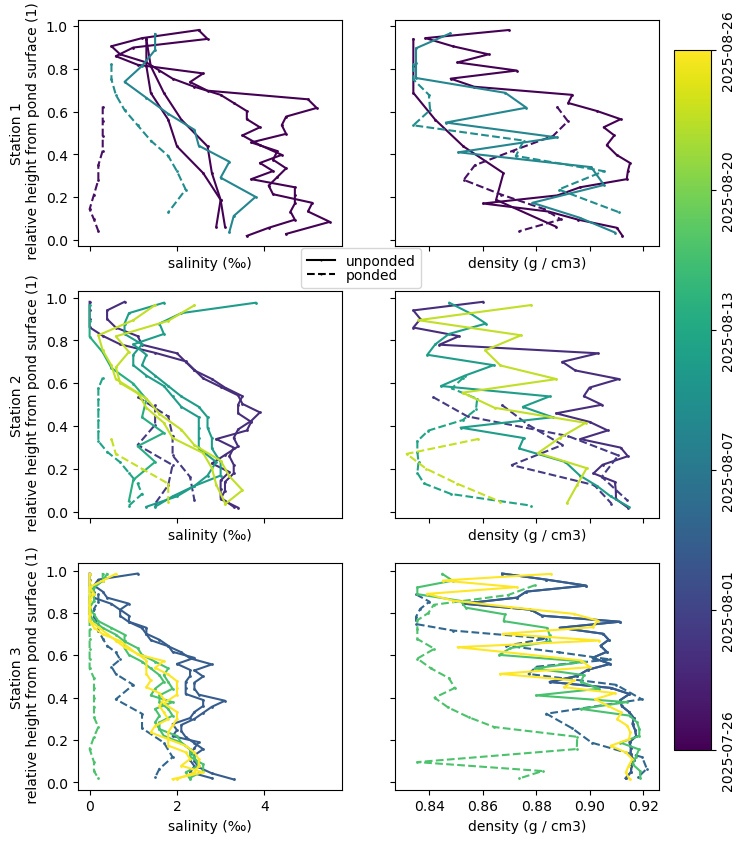

In [138]:
# Plot all salinities and densities
f, axs = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(7.5, 10))

stations = ['1', '2', '3']

z_ref = 'pond surface'
z_scale = 'relative'
pallette = 'viridis'
kind = 'center'
markersize = 1

cmap = cm.get_cmap(pallette)
min_time = df_cores.query('visit in @visits').timestamp.min()
max_time = df_cores.query('visit in @visits').timestamp.max()

for i, station in enumerate(stations):
    df_temp = df_cores.query('station == @station & visit in @visits').reset_index()
    for tup in df_temp.itertuples():
        if tup[3] == '20250730-PS149_25-1-SI_corer_9cm-021-SMYI-RHO':
            continue # input is missing draft and freeboard, skip for now
        
        visit = tup[2]
        ic = tup[4]
        if ic.ponded:
            ls = 'dashed'
        else:
            ls = 'solid'
        color = cmap((tup[5] - min_time)/(max_time - min_time))
        if 'salinity' in ic.units:
            #print(tup[3])
            ic.plot_profile(axs[i,0], 'salinity', z_ref=z_ref,
                            z_scale=z_scale,
                            color=color, linestyle=ls,
                           kind=kind, markersize=markersize)
        if 'density' in ic.units:
            #print(tup[3])
            ic.plot_profile(axs[i,1], 'density', z_ref=z_ref,
                            z_scale=z_scale,
                            color=color, linestyle=ls,
                           kind=kind, markersize=markersize)
    # Update ylabel
    ylbl = axs[i,0].get_ylabel()
    axs[i,0].set_ylabel(f'Station {station}\n {ylbl}')
    axs[i,1].set_ylabel('')

# Add colorbar
nticks = 6
norm = Normalize(vmin=0, vmax=1)
f.subplots_adjust(right=0.9)
cbar_ax = f.add_axes([0.92, 0.15, 0.05, 0.7])
ticks = np.linspace(0, 1, nticks)
tick_labels = pd.date_range(start=min_time, end=max_time, periods=nticks
                           ).strftime('%Y-%m-%d').to_numpy()
f.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
           cax=cbar_ax, orientation='vertical',
          ticks=ticks, aspect=80, shrink=0.5)
cbar_ax.set_yticklabels(tick_labels, rotation=90, va="center")


# Add legend
solid_line = mlines.Line2D([], [], color = 'k', marker='.',
                           markersize=markersize, label='unponded')
dashed_line = mlines.Line2D([], [], color = 'k', marker='.', linestyle='dashed',
                           markersize=markersize, label='ponded')
axs[0,0].legend(handles=[solid_line, dashed_line], bbox_to_anchor=(1.3, -0.01),
                borderaxespad=0., labelspacing=0.0)
plt.show()

f.savefig(os.path.join('..', 'figures', 
    f'contrasts_pond_sal_dens_{z_ref.replace(' ', '-')}_{z_scale}_{kind}.png'),
          bbox_inches='tight')

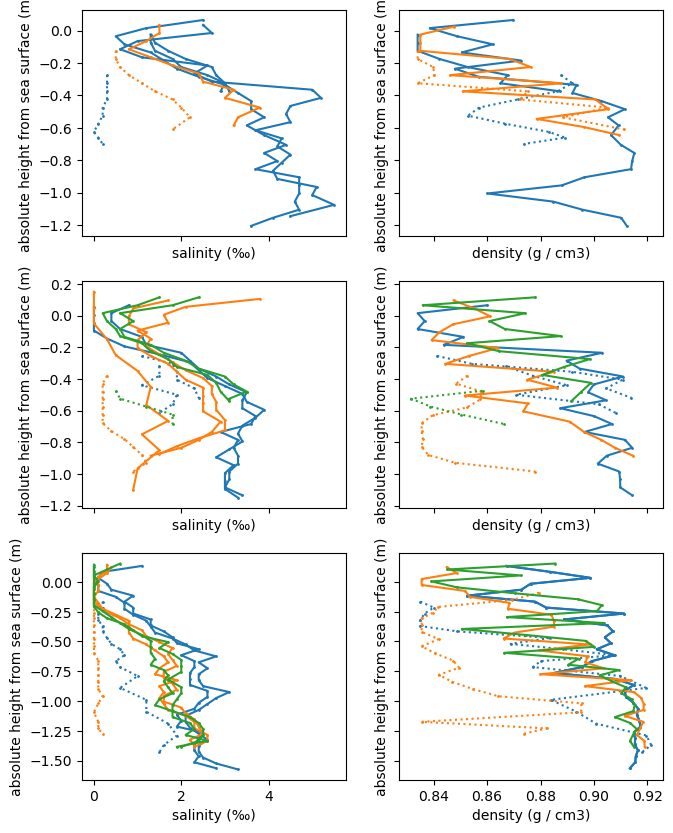

In [224]:
# Plot all salinities and densities
f, axs = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(7.5, 10))

stations = ['1', '2', '3']

color_dict = {'b': 'C0',
              'c': 'C1',
              'd': 'C2',
             }

kind = 'center'
markersize = 1

for i, station in enumerate(stations):
    df_temp = df_cores.query('station == @station').reset_index()
    for tup in df_temp.itertuples():
        if tup[3] == '20250730-PS149_25-1-SI_corer_9cm-021-SMYI-RHO':
            continue # input is missing draft and freeboard, skip for now
        
        visit = tup[2]
        ic = tup[4]
        if ic.ponded:
            ls = 'dotted'
        else:
            ls = 'solid'
        if 'salinity' in ic.units:
            #print(tup[3])
            ic.plot_profile(axs[i,0], 'salinity', z_ref='sea surface',
                            color=color_dict[visit], linestyle=ls,
                           kind=kind, markersize=markersize)
        if 'density' in ic.units:
            #print(tup[3])
            ic.plot_profile(axs[i,1], 'density', z_ref='sea surface',
                            color=color_dict[visit], linestyle=ls,
                           kind=kind, markersize=markersize)

In [19]:
## Plot comparison of bare ice MOSAiC and Contrasts salinities and densities

In [105]:
df_cores_mosaic.timestamp.dt.dayofyear

station     visit         
MOSAiC_FYI  PS122/1_10-19     336
            PS122/1_5-3       300
            PS122/1_6-34      308
            PS122/1_7-6       315
            PS122/1_7-97      322
            PS122/1_8-2       322
            PS122/1_9-6       329
            PS122/1_9-93      334
            PS122/2_17-3      357
            PS122/2_19-7        6
            PS122/2_21-13      20
            PS122/2_23-3       34
            PS122/2_24-8       41
            PS122/3_32-63      81
            PS122/3_35-11      97
            PS122/3_36-21     105
            PS122/3_38-24     118
            PS122/3_39-7      125
            PS122/4_44-134    174
            PS122/4_46-18     188
            PS122/4_47-16     196
            PS122/4_48-23     202
            PS122/4_49-34     211
MOSAiC_SYI  PS122/1_10-16     336
            PS122/1_5-78      301
            PS122/1_6-36      308
            PS122/1_7-53      320
            PS122/1_7-9       315
            PS122/1_9

/tmp/ipykernel_31965/3731788106.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(pallette)


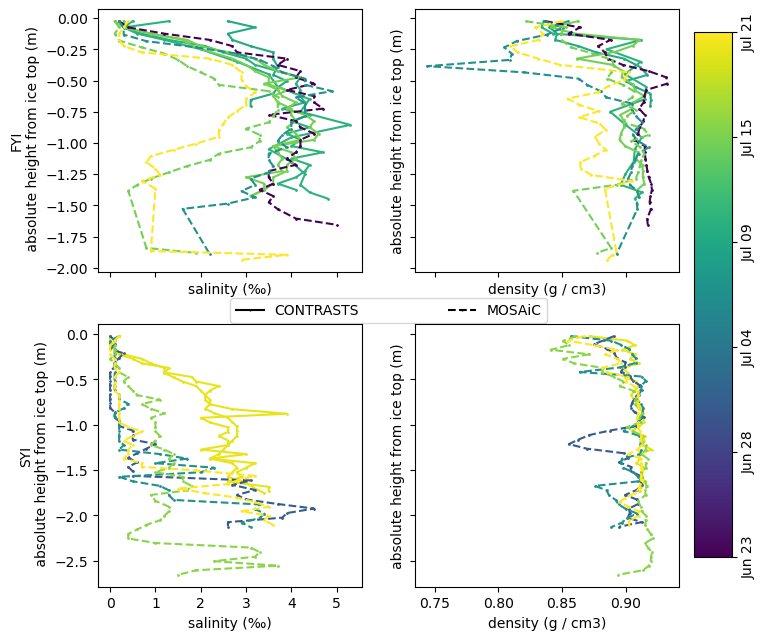

In [116]:
# Plot all salinities and densities
#f, axs = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(7.5, 10))

z_ref = 'ice top'
z_scale = 'absolute'
pallette = 'viridis'
kind = 'center'
markersize = 1

cmap = cm.get_cmap(pallette)
min_doy = 174 #188 #125#
max_doy = 202

# Plot all salinities and densities
f, axs = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(7.5, 7.5))

## FYI
stations = ["1", "2"]
df_temp = df_cores.query('station in @stations').reset_index()
df_temp['doy'] = df_temp.timestamp.dt.dayofyear
df_temp = df_temp[(df_temp.doy >= min_doy) & (df_temp.doy <= max_doy)]
ls = 'solid'
for tup in df_temp.itertuples():
    if tup[3] == '20250730-PS149_25-1-SI_corer_9cm-021-SMYI-RHO':
        continue # input is missing draft and freeboard, skip for now
    
    visit = tup[2]
    ic = tup[4]
    if ic.ponded:
        continue
    color = cmap((tup[6] - min_doy)/(max_doy - min_doy))
    if 'salinity' in ic.units:
        #print(tup[3])
        ic.plot_profile(axs[0,0], 'salinity', z_ref=z_ref,
                        z_scale=z_scale,
                        color=color, linestyle=ls,
                       kind=kind, markersize=markersize)
    if 'density' in ic.units:
        #print(tup[3])
        ic.plot_profile(axs[0,1], 'density', z_ref=z_ref,
                        z_scale=z_scale,
                        color=color, linestyle=ls,
                       kind=kind, markersize=markersize)


## MOSAiC
df_temp = df_cores_mosaic[(df_cores_mosaic.timestamp.dt.dayofyear >= min_doy) 
                         & (df_cores_mosaic.timestamp.dt.dayofyear <= max_doy)].query(
    'station == "MOSAiC_FYI"').reset_index()
df_temp['doy'] = df_temp.timestamp.dt.dayofyear
ls = 'dashed' #dashed lines for mosaic
for tup in df_temp.itertuples():
    ic = tup[3]
    color = cmap((tup[5] - min_doy)/(max_doy - min_doy))
    if 'salinity' in ic.units:
        ic.plot_profile(axs[0,0], 'salinity', z_ref=z_ref,
                        z_scale=z_scale,
                        color=color, linestyle=ls,
                       kind=kind, markersize=markersize)
    if 'density' in ic.units:
        #print(tup[3])
        ic.plot_profile(axs[0,1], 'density', z_ref=z_ref,
                        z_scale=z_scale,
                        color=color, linestyle=ls,
                       kind=kind, markersize=markersize)
# Update ylabel
ylbl = axs[0,0].get_ylabel()
axs[0,0].set_ylabel(f'FYI\n {ylbl}')


## SYI
stations = ["3"]
df_temp = df_cores.query('station in @stations').reset_index()
df_temp['doy'] = df_temp.timestamp.dt.dayofyear
df_temp = df_temp[(df_temp.doy >= min_doy) & (df_temp.doy <= max_doy)]
ls = 'solid'
for tup in df_temp.itertuples():
    if tup[3] == '20250730-PS149_25-1-SI_corer_9cm-021-SMYI-RHO':
        continue # input is missing draft and freeboard, skip for now
    
    visit = tup[2]
    ic = tup[4]
    if ic.ponded:
        continue
    color = cmap((tup[6] - min_doy)/(max_doy - min_doy))
    if 'salinity' in ic.units:
        #print(tup[3])
        ic.plot_profile(axs[1,0], 'salinity', z_ref=z_ref,
                        z_scale=z_scale,
                        color=color, linestyle=ls,
                       kind=kind, markersize=markersize)
    if 'density' in ic.units:
        #print(tup[3])
        ic.plot_profile(axs[1,1], 'density', z_ref=z_ref,
                        z_scale=z_scale,
                        color=color, linestyle=ls,
                       kind=kind, markersize=markersize)
## MOSAiC
df_temp = df_cores_mosaic[(df_cores_mosaic.timestamp.dt.dayofyear >= min_doy) 
                         & (df_cores_mosaic.timestamp.dt.dayofyear <= max_doy)].query(
    'station == "MOSAiC_SYI"').reset_index()
df_temp['doy'] = df_temp.timestamp.dt.dayofyear
ls = 'dashed' #dashed lines for mosaic
for tup in df_temp.itertuples():
    ic = tup[3]
    color = cmap((tup[5] - min_doy)/(max_doy - min_doy))
    if 'salinity' in ic.units:
        ic.plot_profile(axs[1,0], 'salinity', z_ref=z_ref,
                        z_scale=z_scale,
                        color=color, linestyle=ls,
                       kind=kind, markersize=markersize)
    if 'density' in ic.units:
        #print(tup[3])
        ic.plot_profile(axs[1,1], 'density', z_ref=z_ref,
                        z_scale=z_scale,
                        color=color, linestyle=ls,
                       kind=kind, markersize=markersize)
# Update ylabel
ylbl = axs[1,0].get_ylabel()
axs[1,0].set_ylabel(f'SYI\n {ylbl}')

# Add colorbar
nticks = 6
norm = Normalize(vmin=0, vmax=1)
f.subplots_adjust(right=0.9)
cbar_ax = f.add_axes([0.92, 0.15, 0.05, 0.7])
ticks = np.linspace(0, 1, nticks)
tick_labels = pd.date_range(start=pd.to_datetime(min_doy-1, unit='D', origin='2025'),
                            end=pd.to_datetime(max_doy-1, unit='D', origin='2025'), periods=nticks
                           ).strftime('%b %d').to_numpy()
f.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
           cax=cbar_ax, orientation='vertical',
          ticks=ticks, aspect=80, shrink=0.5)
cbar_ax.set_yticklabels(tick_labels, rotation=90, va="center")

# Add legend
solid_line = mlines.Line2D([], [], color = 'k', marker='.',
                           markersize=markersize, label='CONTRASTS')
dashed_line = mlines.Line2D([], [], color = 'k', marker='.', linestyle='dashed',
                           markersize=markersize, label='MOSAiC')
axs[0,0].legend(handles=[solid_line, dashed_line], bbox_to_anchor=(0.5, -0.07, 1.2, -0.03),
                ncols=2, mode="expand", borderaxespad=0.)

plt.show()

f.savefig(os.path.join('..', 'figures', 
    f'contrasts_mosaic_sal_dens_{z_ref.replace(' ', '-')}_{z_scale}_{kind}.png'),
          bbox_inches='tight')

In [139]:
df_temp = df_cores_mosaic[(df_cores_mosaic.timestamp.dt.dayofyear >= min_doy) 
                         & (df_cores_mosaic.timestamp.dt.dayofyear <= max_doy)].query(
    'station == "MOSAiC_FYI"').reset_index()
df_temp['doy'] = df_temp.timestamp.dt.dayofyear
df_temp['salinity'] = 0.0

for i in np.arange(df_temp.shape[0]):
    df_temp.at[i, 'salinity'] = df_temp.at[i, 'core'].bulk_property('salinity')

print(df_temp)

      station           visit                                            core  \
0  MOSAiC_FYI  PS122/4_44-134  <__main__.MosaicCore object at 0x7f682295ac30>   
1  MOSAiC_FYI   PS122/4_46-18  <__main__.MosaicCore object at 0x7f6822947170>   
2  MOSAiC_FYI   PS122/4_47-16  <__main__.MosaicCore object at 0x7f6822c366c0>   
3  MOSAiC_FYI   PS122/4_48-23  <__main__.MosaicCore object at 0x7f6823181ee0>   

                  timestamp  doy  salinity  
0 2020-06-22 10:00:00+00:00  174  3.579518  
1 2020-07-06 10:00:00+00:00  188  3.109657  
2 2020-07-14 07:58:00+00:00  196  1.968350  
3 2020-07-20 11:52:00+00:00  202  1.798675  


In [146]:
stations = ["1", "2"]
df_temp = df_cores.query('station in @stations').reset_index()
df_temp['doy'] = df_temp.timestamp.dt.dayofyear
df_temp = df_temp[(df_temp.doy >= min_doy) & (df_temp.doy <= max_doy)]
cores = []
for i, core in enumerate(df_temp.core):
    if 'salinity' in core.units:
        cores.append(i)

df_temp = df_temp.iloc[cores].reset_index(drop=True)
df_temp['salinity'] = 0.0

for i in np.arange(df_temp.shape[0]):
    df_temp.at[i, 'salinity'] = df_temp.at[i, 'core'].bulk_property('salinity')

print(df_temp)

  station visit                                             name  \
0       1     a     20250710-PS149_13-1-SI_corer_9cm-017-FYI-RHO   
1       1     a  20250710-PS149_13-1-SI_corer_9cm-018-FYI-SALO18   
2       1     a   20250711-PS149_13-1-SI_corer_9cm-22-FYI-SALO18   
3       1     a      20250711-PS149_13-1-SI_corer_9cm-23-FYI-RHO   
4       2     a  20250715-PS149_16-1-SI_corer_9cm-016-FYI-SALO18   
5       2     a     20250715-PS149_16-1-SI_corer_9cm-019-FYI-RHO   

                                          core                 timestamp  doy  \
0  <__main__.IceCore object at 0x7f681ebae0c0> 2025-07-10 12:00:00+00:00  191   
1  <__main__.IceCore object at 0x7f681d233f80> 2025-07-10 09:17:00+00:00  191   
2  <__main__.IceCore object at 0x7f6822b602c0> 2025-07-11 15:49:00+00:00  192   
3  <__main__.IceCore object at 0x7f681eb83380> 2025-07-11 15:49:00+00:00  192   
4  <__main__.IceCore object at 0x7f681e2fd580> 2025-07-15 09:04:00+00:00  196   
5  <__main__.IceCore object at 0x7f68

In [278]:
# Summarize bulk properties
cores_exclude = ['20250726-PS149_21-1-SI_corer_9cm-020-FYI-lead-T',
                 '20250726-PS149_21-1-SI_corer_9cm-021-FYI-lead-SALO18',
                 '20250726-PS149_21-1-SI_corer_9cm-022-FYI-lead-RHO',
                 '20250730-PS149_25-1-SI_corer_9cm-021-SMYI-RHO',
                ]

ls_s = []
ls_r = []
ls_p = []
ls_a = []
df_temp = df_cores.query('name not in @cores_exclude')
for idx, ic in df_temp.core.items():
    if 'salinity' in ic.units:
        ls_s.append(ic.bulk_property('salinity'))
    else:
        ls_s.append(np.nan)
    if 'density' in ic.units:
        ls_r.append(ic.bulk_property('density'))
    else:
        ls_r.append(np.nan)
    ls_p.append(ic.ponded)
    ls_a.append(ic.age)
df_bulk = pd.DataFrame({'salinity': ls_s, 'density': ls_r, 
                        'ponded': ls_p, 'age': ls_a}, index=df_temp.index)
df_bulk.set_index(['ponded', 'age'], append=True, inplace=True)
df_bulk = df_bulk.melt(ignore_index=False).dropna(how='any')
df_bulk = df_bulk.reset_index().drop(columns=['name']).groupby(
    by=['station', 'visit', 'ponded', 'age', 'variable']).mean()

In [280]:
df_bulk.query('variable == "salinity"').reset_index().drop(columns='variable'
    ).pivot(index=['station','visit'], columns=['age', 'ponded'], values='value')

age           FY (first year)           SY (second year)          
ponded                  False     True             False     True 
station visit                                                     
1       b            3.489162  0.206250              NaN       NaN
        c            2.314925  1.332727              NaN       NaN
2       b            2.441778  1.739777              NaN       NaN
        c            2.005825       NaN         0.803650  0.521212
        d            1.755215       NaN              NaN  1.225926
3       b                 NaN       NaN         1.794286  0.870455
        c                 NaN       NaN         1.257419  0.055645
        d                 NaN       NaN         1.209878       NaN

In [281]:
df_bulk.query('variable == "density"').reset_index().drop(columns='variable'
    ).pivot(index=['station','visit'], columns=['age', 'ponded'], values='value')

age           FY (first year)           SY (second year)          
ponded                  False     True             True      False
station visit                                                     
1       b            0.887525  0.875120              NaN       NaN
        c            0.870453  0.866960              NaN       NaN
2       b            0.889040  0.886325              NaN       NaN
        c            0.871245       NaN         0.847770       NaN
        d            0.876995       NaN         0.850345       NaN
3       b                 NaN       NaN         0.886375  0.901609
        c                 NaN       NaN         0.854972  0.888365
        d                 NaN       NaN              NaN  0.892648

In [289]:
# Summarize bulk properties
cores_exclude = ['20250726-PS149_21-1-SI_corer_9cm-020-FYI-lead-T',
                 '20250726-PS149_21-1-SI_corer_9cm-021-FYI-lead-SALO18',
                 '20250726-PS149_21-1-SI_corer_9cm-022-FYI-lead-RHO',
                 '20250730-PS149_25-1-SI_corer_9cm-021-SMYI-RHO',
                ]

ls_s = []
ls_r = []
ls_p = []
ls_l = []
df_temp = df_cores.query('name not in @cores_exclude')
for idx, ic in df_temp.core.items():
    if 'salinity' in ic.units:
        ls_s.append(ic.bulk_property('salinity'))
    else:
        ls_s.append(np.nan)
    if 'density' in ic.units:
        ls_r.append(ic.bulk_property('density'))
    else:
        ls_r.append(np.nan)
    ls_p.append(ic.ponded)
    ls_l.append(ic.length)
df_bulk = pd.DataFrame({'salinity': ls_s, 'density': ls_r, 
                        'ponded': ls_p, 'length': ls_l}, index=df_temp.index)
df_bulk.set_index('ponded', append=True, inplace=True)
df_bulk = df_bulk.melt(ignore_index=False).dropna(how='any')
df_bulk = df_bulk.reset_index().drop(columns=['name']).groupby(
    by=['station', 'visit', 'ponded', 'variable']).mean()

In [290]:
df_bulk.reset_index().pivot(index=['station','visit'], columns=['variable', 'ponded'], 
                            values='value').sort_index(axis=1, level='variable')

variable        density              length         salinity          
ponded            False     True      False  True      False     True 
station visit                                                         
1       b      0.887525  0.875120  1.240000  0.480  3.489162  0.206250
        c      0.870453  0.866960  0.712500  0.600  2.314925  1.332727
2       b      0.889040  0.886325  1.408333  0.335  2.441778  1.739777
        c      0.871245  0.847770  1.102000  0.660  1.605100  0.521212
        d      0.876995  0.850345  0.730000  0.270  1.755215  1.225926
3       b      0.901609  0.886375  1.750000  1.325  1.794286  0.870455
        c      0.888365  0.854972  1.560000  1.240  1.257419  0.055645
        d      0.892648       NaN  1.587500    NaN  1.209878       NaN

In [313]:
## rough freeboard estimation
s_frac = pd.Series([0.7, 0.3], index=pd.Index([False, True], name='ponded'), name='fraction')
df_temp_true = pd.merge(df_bulk.query('variable in ["density", "length"]').reset_index(level='variable').pivot(columns='variable', values='value'),
                        s_frac, left_index=True, right_index=True)
# phi_i is volume fraction ice, could make different for ponded and unponded
df_temp_true['phi_i'] = 0.9

# Pond buoyancy force is how many kg of ice per m2 the pond can support
rhow = 1026
df_pond_buoy = ((rhow - df_temp_true['density']*1e3)*df_temp_true['length']*df_temp_true['fraction']*df_temp_true['phi_i']
    ).reset_index('ponded').query('ponded').drop(columns='ponded').rename(columns={0: 'pond_ice_buoyancy_kg_m2'})

df_temp_true = pd.merge(df_temp_true.query('not ponded').reset_index('ponded', drop=True),
                        df_pond_buoy, left_index=True, right_index=True)

df_temp_true['bi_fbd_m'] = (df_temp_true['length']*(rhow - df_temp_true['density']*1e3)/rhow 
                            + df_temp_true['pond_ice_buoyancy_kg_m2']/(df_temp_true['fraction']*df_temp_true['phi_i']*rhow))
df_temp_true['fbd_m'] = df_temp_true['bi_fbd_m'] * df_temp_true['fraction']
#df_temp_true['mass_per_m2'] = 1000*df_temp_true['density']*df_temp_true['length']

In [314]:
df_temp_true

density    length  fraction  phi_i  pond_ice_buoyancy_kg_m2  \
station visit                                                                 
1       b      0.887525  1.240000       0.7    0.9                19.554059   
        c      0.870453  0.712500       0.7    0.9                25.764522   
2       b      0.889040  1.408333       0.7    0.9                12.633587   
        c      0.871245  1.102000       0.7    0.9                31.760604   
        d      0.876995  0.730000       0.7    0.9                12.805283   
3       b      0.901609  1.750000       0.7    0.9                49.950803   
        c      0.888365  1.560000       0.7    0.9                57.260161   

               bi_fbd_m     fbd_m  
station visit                      
1       b      0.197609  0.138326  
        c      0.147879  0.103515  
2       b      0.207543  0.145280  
        c      0.215354  0.150748  
        d      0.125828  0.088080  
3       b      0.289446  0.202612  
        c      0.297856  0.208499

In [326]:
## rough freeboard estimation
s_frac = pd.Series([0.7, 0.3], index=pd.Index([False, True], name='ponded'), name='fraction')
df_temp = df_bulk.query('variable == "density" & not ponded').reset_index()
df_temp['ponded'] = True
df_temp = df_temp.set_index(['station', 'visit', 'ponded', 'variable']).combine_first(df_bulk)
df_temp_wrongpond = pd.merge(df_temp.query('variable in ["density", "length"]').reset_index(level='variable').pivot(columns='variable', values='value'),
                        s_frac, left_index=True, right_index=True)
# phi_i is volume fraction ice, could make different for ponded and unponded
df_temp_wrongpond['phi_i'] = 0.9

# Pond buoyancy force is how many kg of ice per m2 the pond can support
rhow = 1026
df_pond_buoy = ((rhow - df_temp_wrongpond['density']*1e3)*df_temp_wrongpond['length']*df_temp_wrongpond['fraction']*df_temp_wrongpond['phi_i']
    ).reset_index('ponded').query('ponded').drop(columns='ponded').rename(columns={0: 'pond_ice_buoyancy_kg_m2'})

df_temp_wrongpond = pd.merge(df_temp_wrongpond.query('not ponded').reset_index('ponded', drop=True),
                        df_pond_buoy, left_index=True, right_index=True)

df_temp_wrongpond['bi_fbd_m'] = (df_temp_wrongpond['length']*(rhow - df_temp_wrongpond['density']*1e3)/rhow 
                            + df_temp_wrongpond['pond_ice_buoyancy_kg_m2']/(df_temp_wrongpond['fraction']*df_temp_wrongpond['phi_i']*rhow))
df_temp_wrongpond['fbd_m'] = df_temp_wrongpond['bi_fbd_m'] * df_temp_wrongpond['fraction']
#df_temp_true['mass_per_m2'] = 1000*df_temp_true['density']*df_temp_true['length']

In [327]:
df_temp_wrongpond

density    length  fraction  phi_i  pond_ice_buoyancy_kg_m2  \
station visit                                                                 
1       b      0.887525  1.240000       0.7    0.9                17.946331   
        c      0.870453  0.712500       0.7    0.9                25.198665   
2       b      0.889040  1.408333       0.7    0.9                12.388052   
        c      0.871245  1.102000       0.7    0.9                27.577318   
        d      0.876995  0.730000       0.7    0.9                10.862490   
3       b      0.901609  1.750000       0.7    0.9                44.500888   
        c      0.888365  1.560000       0.7    0.9                46.080328   
        d      0.892648  1.587500       0.7    0.9                      NaN   

               bi_fbd_m     fbd_m  
station visit                      
1       b      0.195122  0.136585  
        c      0.147003  0.102902  
2       b      0.207163  0.145014  
        c      0.208882  0.146218  
        d      0.122823  0.085976  
3       b      0.281014  0.196710  
        c      0.280560  0.196392  
        d           NaN       NaN

In [232]:
## Rough FYI salt impacts
cores_exclude = ['20250726-PS149_21-1-SI_corer_9cm-020-FYI-lead-T',
                 '20250726-PS149_21-1-SI_corer_9cm-021-FYI-lead-SALO18',
                 '20250726-PS149_21-1-SI_corer_9cm-022-FYI-lead-RHO',
                 '20250730-PS149_25-1-SI_corer_9cm-021-SMYI-RHO',
                ]

# MOSAiC reference:
init_salt = df_cores_mosaic.at[('MOSAiC_FYI', 'PS122/3_39-7'), 'core'].total_salt()

# Get CONTRASTS cores
rho_fixed = None #0.89

visits = ['b', 'c', 'd']
stations = ['1', '2']
df_temp = df_cores.query('(visit in @visits) & (station in @stations)'+
                        ' & (name not in @cores_exclude)').reset_index()
ls_st = []
ls_v = []
ls_n = []
ls_p = []
ls_l = []
ls_salt = []
ls_t = []

for tup in df_temp.itertuples():
    if {"salinity", "density"}.issubset(tup[4].units.keys()):
        ls_st.append(tup[1])
        ls_v.append(tup[2])
        ls_n.append(tup[3])
        ls_p.append(tup[4].ponded)
        ls_l.append(tup[4].length)
        ls_salt.append(tup[4].total_salt(density=rho_fixed))
        
df_temp = pd.DataFrame({'station': ls_st,
                        'visit': ls_v,
                        'name': ls_n,
                        'ponded': ls_p,
                        'length': ls_l,
                        'salt': ls_salt,
                       })

df_area_fraction = pd.DataFrame({'ponded': [True, False],
                                 'area': [0.3, 0.7]})
# Compute the amount of salt per meter of ice thickness
df_temp = pd.merge(df_temp, df_area_fraction, on='ponded')
df_temp = df_temp.drop(columns='name').groupby(['station', 'visit', 'ponded']).mean()
s_salt_kg_m3 = df_temp['salt']/df_temp['length']
s_salt_kg_m3.name = 'salt_kg_m3'

# Hack for estimating thicknesses and area fractions of ponded and unponded areas
# replace with data from transects eventually
df_hi_area = df_temp[['length', 'area']].rename(columns={'length': 'hi'})
df_hi_total = (df_hi_area['hi']*df_hi_area['area']).reset_index(
    ).groupby(by=['station', 'visit']).sum()
df_hi_area_nopond = df_hi_total.rename(columns={0: 'hi'})
df_hi_area_nopond['ponded'] = False
df_hi_area_nopond['area'] = 1.0
df_hi_area_nopond.set_index('ponded', append=True, inplace=True)

# Compute total salt for both the true case and the no pond case
df_salt_pond = pd.merge(df_hi_area, s_salt_kg_m3, left_index=True, right_index=True)
df_salt_nopond = pd.merge(df_hi_area_nopond, s_salt_kg_m3, left_index=True, right_index=True)
df_salt_pond['salt_kg_m2'] = df_salt_pond['hi']*df_salt_pond['salt_kg_m3']*df_salt_pond['area']
df_salt_nopond['salt_kg_m2'] = df_salt_nopond['hi']*df_salt_nopond['salt_kg_m3']*df_salt_nopond['area']

print('Salt kg/m2, including pond fraction')
print(df_salt_pond.groupby(level=['station', 'visit']).sum()['salt_kg_m2'])
print('Salt kg/m2, assuming pond ice is the same as bare ice')
print(df_salt_nopond['salt_kg_m2'])


Salt kg/m2, including pond fraction
station  visit
1        b        2.710976
         c        0.193410
2        b        2.144681
         c        1.235358
         d        0.783368
Name: salt_kg_m2, dtype: float64
Salt kg/m2, assuming pond ice is the same as bare ice
station  visit  ponded
1        b      False     3.103383
2        b      False     2.218552
         c      False     1.463085
         d      False     0.812504
Name: salt_kg_m2, dtype: float64


In [225]:
df_hi_area_nopond

hi  area
station visit ponded                
1       b     False   1.040000   1.0
        c     False   0.649000   1.0
2       b     False   0.979000   1.0
        c     False   0.998333   1.0
        d     False   0.571000   1.0

In [226]:
df_salt_pond

hi  area  salt_kg_m3
station visit ponded                            
1       b     False   1.280000   0.7    3.098660
              True    0.480000   0.3    0.183562
        c     False   0.670000   0.7    2.060284
              True    0.600000   0.3    1.087283
2       b     False   1.255000   0.7    2.172876
              True    0.335000   0.3    1.540896
        c     False   1.143333   0.7    1.357834
              True    0.660000   0.3    0.463879
        d     False   0.700000   0.7    1.560043
              True    0.270000   0.3    1.091074

In [227]:
df_salt_nopond

hi  area  salt_kg_m3
station visit ponded                            
1       b     False   1.040000   1.0    3.098660
        c     False   0.649000   1.0    2.060284
2       b     False   0.979000   1.0    2.172876
        c     False   0.998333   1.0    1.357834
        d     False   0.571000   1.0    1.560043

In [169]:
# Testing class
station = '1'
visit = 'b'

filepaths = glob.glob(os.path.join(ic_data_root, f"IceStation{station}{visit}", '**', '[!~]*.xlsx'))

In [170]:
filepaths

['../data/ice_coring/IceStation1b/26jul2025coring/20250726-PS149_21-1-SI_corer_9cm-016-FYI-T.xlsx',
 '../data/ice_coring/IceStation1b/26jul2025coring/20250726-PS149_21-1-SI_corer_9cm-017-FYI-REP.xlsx',
 '../data/ice_coring/IceStation1b/26jul2025coring/20250726-PS149_21-1-SI_corer_9cm-018-FYI-SALO18.xlsx',
 '../data/ice_coring/IceStation1b/26jul2025coring/20250726-PS149_21-1-SI_corer_9cm-019-FYI-RHO.xlsx',
 '../data/ice_coring/IceStation1b/26jul2025coring/20250726-PS149_21-1-SI_corer_9cm-020-FYI-lead-T.xlsx',
 '../data/ice_coring/IceStation1b/26jul2025coring/20250726-PS149_21-1-SI_corer_9cm-021-FYI-lead-SALO18.xlsx',
 '../data/ice_coring/IceStation1b/26jul2025coring/20250726-PS149_21-1-SI_corer_9cm-022-FYI-lead-RHO.xlsx',
 '../data/ice_coring/IceStation1b/27jul2025coring_melt_pond/20250727-PS149_21-1-SI_corer_9cm-023-FYI-melt_pond-RHO.xlsx']

In [171]:
self = IceCore(station, visit, filepaths[7])

In [172]:
self.load_salinity()

In [173]:
self.load_densimetry()

In [174]:
self.bulk_property('salinity')

0.20625

In [175]:
self.data

value
variable depth_top depth_bottom depth_center          
salinity 0.0       0.05         0.025         0.300000
         0.05      0.1          0.075         0.300000
         0.1       0.15         0.125         0.300000
         0.15      0.2          0.175         0.300000
         0.2       0.25         0.225         0.200000
         0.25      0.3          0.275         0.200000
         0.3       0.35         0.325         0.100000
         0.35      0.4          0.375         0.000000
         0.4       0.42         0.41          0.100000
         0.42      0.48         0.45          0.200000
density  0.0       0.05         0.025         0.887701
         0.05      0.1          0.075         0.891841
         0.1       0.15         0.125         0.886287
         0.15      0.2          0.175         0.871442
         0.2       0.25         0.225         0.857036
         0.25      0.3          0.275         0.852846
         0.3       0.35         0.325         0.866869
         0.35      0.4          0.375         0.883019
         0.4       0.42         0.41          0.889191
         0.42      0.48         0.45          0.873695

In [176]:
self.total_salt()

0.08675494969194099

In [177]:
self.total_salt(density=0.9)

0.08910000000000001

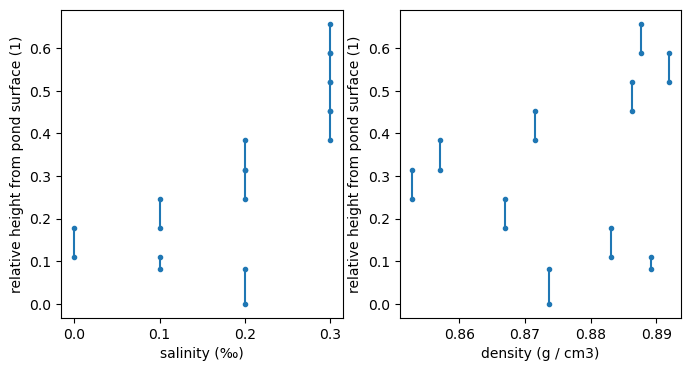

In [128]:
# Test plotting
f, axs = plt.subplots(1, 2, figsize=(8, 4))

z_ref = 'pond surface'#'sea surface'#'ice top'#
z_scale = 'relative'#'absolute'#
kind = 'segment'#'center'
markersize = 3

ax = axs[0]
variable = 'salinity'
self.plot_profile(ax, variable, z_ref=z_ref, z_scale=z_scale, kind=kind,
                 markersize=markersize)

ax = axs[1]
variable = 'density'
self.plot_profile(ax, variable, z_ref=z_ref, z_scale=z_scale, kind=kind,
                 markersize=markersize)

In [421]:
## Explore loading mosaic data

# Paths
mos_data_root = os.path.join('..', '..', 'mosaic', 'data')

mos_fyi_filename = 'MOSAiC_MCS_FYI_sea_ice_nutrients.tab'
mos_syi_filename = 'MOSAiC_MCS_SYI_sea_ice_nutrients.tab'

df_mos_fyi = pd.read_table(os.path.join(mos_data_root, mos_fyi_filename), skiprows=101)
df_mos_syi = pd.read_table(os.path.join(mos_data_root, mos_syi_filename), skiprows=98)

In [422]:
df_mos_syi

,Event,Date/Time,Latitude (coordinates of the ice coring...),Longitude (coordinates of the ice coring...),EsEs [m] (Distance from the top of ice ...),Sea ice draft [m] (Distance from water level to ...),Core length [m] (Total length of the extracted...),"Depth ice/snow top [m] (top of ice layer sampled, mea...)","Depth ice/snow bot [m] (bottom of ice layer sampled, ...)","Depth adj top [ambsf] (top of ice layer sampled, rel...)",...,"[PO4]3- std dev [±] (Continuous flow analyser, Sea...)",QF [PO4]3-,"Si(OH)4 [µmol/l] (Continuous flow analyser, Sea...)",Si(OH)4 std dev [±],QF Si(OH)4,Sample ID (unique identifier for each is...),"δ18O H2O [‰ SMOW] (ppt, vs. VSMOW, Mass spectrom...)","δD H2O [‰ SMOW] (ppt, vs. VSMOW, Mass spectrom...)",d xs [‰] (Calculated after Dansgaard (1...),Comment (Original or new coring site l...)
0,PS122/1_5-78,2019-10-28T05:30:00,85.5510,126.3299,0.77,0.74,0.79,0.00,-0.05,0.03,...,0.002,2.0,0.098,0.040,2.0,122-1_5 SYI 1,-5.33,-41.40,1.21,NaN
1,PS122/1_5-78,2019-10-28T05:30:00,85.5510,126.3299,0.77,0.74,0.79,-0.05,-0.10,-0.02,...,0.001,2.0,0.112,0.007,2.0,122-1_5 SYI 2,-4.22,-33.00,0.78,NaN
2,PS122/1_5-78,2019-10-28T05:30:00,85.5510,126.3299,0.77,0.74,0.79,-0.10,-0.15,-0.07,...,0.001,2.0,0.146,0.000,2.0,122-1_5 SYI 3,-3.74,-29.61,0.32,NaN
3,PS122/1_5-78,2019-10-28T05:30:00,85.5510,126.3299,0.77,0.74,0.79,-0.15,-0.20,-0.12,...,0.003,2.0,0.182,0.006,2.0,122-1_5 SYI 4,-3.47,-27.18,0.55,NaN
4,PS122/1_5-78,2019-10-28T05:30:00,85.5510,126.3299,0.77,0.74,0.79,-0.20,-0.25,-0.17,...,0.001,2.0,0.150,0.014,2.0,122-1_5 SYI 5,-3.44,-26.55,0.95,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,PS122/4_48-25,2020-07-20T10:00:00,80.7709,-0.4850,2.06,1.76,2.07,-1.88,-1.93,-1.58,...,0.001,2.0,0.193,0.006,2.0,PS122_48_25-SYI-DO18-39,-0.16,-0.30,1.00,new coring site location
577,PS122/4_48-25,2020-07-20T10:00:00,80.7709,-0.4850,2.06,1.76,2.07,-1.93,-1.98,-1.63,...,0.003,2.0,0.192,0.001,2.0,PS122_48_25-SYI-DO18-40,0.03,0.80,0.60,new coring site location
578,PS122/4_48-25,2020-07-20T10:00:00,80.7709,-0.4850,2.06,1.76,2.07,-1.98,-2.03,-1.68,...,0.002,2.0,0.176,0.001,2.0,PS122_48_25-SYI-DO18-41,0.17,2.20,0.80,new coring site location
579,PS122/4_48-25,2020-07-20T10:00:00,80.7709,-0.4850,2.06,1.76,2.07,-2.03,-2.08,-1.73,...,0.008,2.0,0.207,0.000,2.0,PS122_48_25-SYI-DO18-42,0.37,4.30,1.30,new coring site location


In [423]:
station = 'MOSAiC_SYI'
visit = 'PS122/1_5-78'#PS122/1_5-3'
file_path = os.path.join(mos_data_root, mos_syi_filename)
test = MosaicCore(station, visit, file_path)

             Event            Date/Time  \
0     PS122/1_5-78  2019-10-28T05:30:00   
1     PS122/1_5-78  2019-10-28T05:30:00   
2     PS122/1_5-78  2019-10-28T05:30:00   
3     PS122/1_5-78  2019-10-28T05:30:00   
4     PS122/1_5-78  2019-10-28T05:30:00   
..             ...                  ...   
576  PS122/4_48-25  2020-07-20T10:00:00   
577  PS122/4_48-25  2020-07-20T10:00:00   
578  PS122/4_48-25  2020-07-20T10:00:00   
579  PS122/4_48-25  2020-07-20T10:00:00   
580  PS122/4_48-25  2020-07-20T10:00:00   

     Latitude (coordinates of the ice coring...)  \
0                                        85.5510   
1                                        85.5510   
2                                        85.5510   
3                                        85.5510   
4                                        85.5510   
..                                           ...   
576                                      80.7709   
577                                      80.7709   
578            

In [424]:
test.age

'SY (first year)'

In [389]:
test.load_salinity()

/tmp/ipykernel_103/3358635168.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, df_data_temp])


In [391]:
test.load_density()

In [392]:
test.data

value
variable depth_top depth_bottom depth_center        
salinity -0.0      0.05         0.025         9.1000
          0.05     0.1          0.075         6.8000
          0.1      0.15         0.125         5.5000
          0.15     0.22         0.185         5.2000
          0.22     0.27         0.245         4.5000
          0.27     0.32         0.295         5.6000
          0.32     0.37         0.345         4.9000
          0.37     0.42         0.395         7.2000
density  -0.0      0.05         0.025         0.8560
          0.05     0.1          0.075         0.8591
          0.1      0.15         0.125         0.8770
          0.15     0.22         0.185         0.9060
          0.22     0.27         0.245         0.9076
          0.27     0.32         0.295         0.9330
          0.32     0.37         0.345         0.9146
          0.37     0.42         0.395         0.8948

In [393]:
test.bulk_property('density')

0.8941071428571429

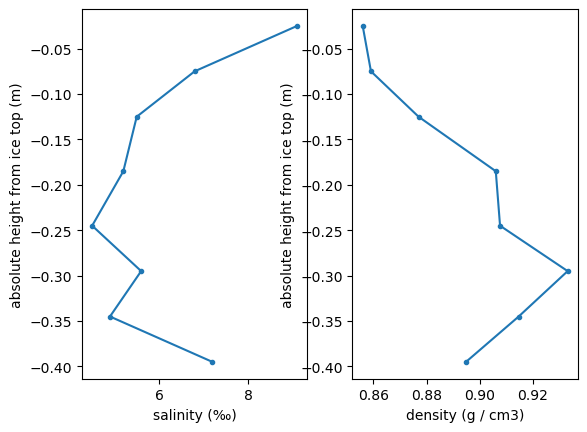

In [394]:
f, axs = plt.subplots(1, 2)

test.plot_profile(axs[0], 'salinity')

test.plot_profile(axs[1], 'density')

In [352]:
df_mosaic = df_mos_fyi[df_mos_fyi.Event == 'PS122/1_5-3']

In [354]:
df_mosaic.columns

Index(['Event', 'Date/Time', 'Latitude (coordinates of the ice coring...)',
       'Longitude (coordinates of the ice coring...)',
       'EsEs [m] (Distance from the top of ice ...)',
       'Sea ice draft [m] (Distance from water level to ...)',
       'Core length [m] (Total length of the extracted...)',
       'Depth ice/snow top [m] (top of ice layer sampled, mea...)',
       'Depth ice/snow bot [m] (bottom of ice layer sampled, ...)',
       'Depth adj top [ambsf] (top of ice layer sampled, rel...)',
       'Depth adj bot [ambsf] (bottom of ice layer sampled, ...)',
       'Depth adj [ambsf] (middle of ice layer sampled, ...)',
       'Sea ice sal (Practical salinity measured a...)',
       't [°C] (Thermometer)',
       'Density ice [kg/m**3] (prime; Sea ice density measur...)',
       'Density ice [kg/m**3] (Sea ice density calculated fr...)',
       'Vol brine [%] (Liquid brine volume fraction ...)',
       'Vol gas [%] (Gas volume fraction calculate...)',
       'Snow h [m] (

In [355]:
cols = ['Event', 
        'Date/Time', 
        'Sea ice draft [m] (Distance from water level to ...)',
        'Core length [m] (Total length of the extracted...)',
        'Snow h [m] (Average snow depth at coring ...)',
       ]
df_mosaic[cols].drop_duplicates(ignore_index=True)

,Event,Date/Time,Sea ice draft [m] (Distance from water level to ...),Core length [m] (Total length of the extracted...),Snow h [m] (Average snow depth at coring ...)
0,PS122/1_5-3,2019-10-27T23:46:00,0.398,0.42,0.089


In [397]:
df_mos_fyi[df_mos_fyi['Density ice [kg/m**3] (prime; Sea ice density measur...)'].isna()]

,Event,Date/Time,Latitude (coordinates of the ice coring...),Longitude (coordinates of the ice coring...),EsEs [m] (Distance from the top of ice ...),Sea ice draft [m] (Distance from water level to ...),Core length [m] (Total length of the extracted...),"Depth ice/snow top [m] (top of ice layer sampled, mea...)","Depth ice/snow bot [m] (bottom of ice layer sampled, ...)","Depth adj top [ambsf] (top of ice layer sampled, rel...)",...,"[PO4]3- std dev [±] (Continuous flow analyser, Sea...)",QF [PO4]3-,"Si(OH)4 [µmol/l] (Continuous flow analyser, Sea...)",Si(OH)4 std dev [±],QF Si(OH)4,Sample ID (unique identifier for each is...),"δ18O H2O [‰ SMOW] (ppt, vs. VSMOW, Mass spectrom...)","δD H2O [‰ SMOW] (ppt, vs. VSMOW, Mass spectrom...)",d xs [‰] (Calculated after Dansgaard (1...),Comment (False bottom and rafted ice f...)
15,PS122/1_6-34,2019-11-04T01:36:00,85.9433,120.2574,0.446,0.402,0.445,-0.39,-0.44,-0.35,...,NaN,2.0,0.621,NaN,2.0,PS122-1_6-FYI 8,NaN,NaN,NaN,NaN
18,PS122/1_7-6,2019-11-11T03:00:00,85.8711,116.2732,0.480,0.470,0.480,-0.10,-0.15,-0.09,...,0.002,2.0,0.470,0.006,2.0,PS122-1_7-FYI-3,NaN,NaN,NaN,NaN
19,PS122/1_7-6,2019-11-11T03:00:00,85.8711,116.2732,0.480,0.470,0.480,-0.15,-0.20,-0.14,...,0.002,2.0,0.735,0.009,2.0,PS122-1_7-FYI-4,-1.69,-13.77,-0.29,NaN
20,PS122/1_7-6,2019-11-11T03:00:00,85.8711,116.2732,0.480,0.470,0.480,-0.20,-0.25,-0.19,...,0.000,2.0,1.162,0.013,2.0,PS122-1_7-FYI-5,0.64,5.16,0.03,NaN
25,PS122/1_7-97,2019-11-18T02:48:00,85.8842,120.9866,0.540,0.530,0.540,0.00,-0.05,0.01,...,NaN,NaN,NaN,NaN,NaN,PS122/1_7 DO18 14,NaN,NaN,NaN,NaN
26,PS122/1_7-97,2019-11-18T02:48:00,85.8842,120.9866,0.540,0.530,0.540,-0.05,-0.10,-0.04,...,NaN,NaN,NaN,NaN,NaN,PS122/1_7 DO18 15,NaN,NaN,NaN,NaN
27,PS122/1_7-97,2019-11-18T02:48:00,85.8842,120.9866,0.540,0.530,0.540,-0.10,-0.15,-0.09,...,NaN,NaN,NaN,NaN,NaN,PS122/1_7 DO18 17,NaN,NaN,NaN,NaN
28,PS122/1_7-97,2019-11-18T02:48:00,85.8842,120.9866,0.540,0.530,0.540,-0.15,-0.20,-0.14,...,NaN,NaN,NaN,NaN,NaN,PS122/1_7 DO18 18,NaN,NaN,NaN,NaN
29,PS122/1_7-97,2019-11-18T02:48:00,85.8842,120.9866,0.540,0.530,0.540,-0.20,-0.25,-0.19,...,NaN,NaN,NaN,NaN,NaN,PS122/1_7 DO18 19,NaN,NaN,NaN,NaN
30,PS122/1_7-97,2019-11-18T02:48:00,85.8842,120.9866,0.540,0.530,0.540,-0.25,-0.30,-0.24,...,NaN,NaN,NaN,NaN,NaN,PS122/1_7 DO18 20,NaN,NaN,NaN,NaN


In [398]:
df_mos_syi[df_mos_syi['Density ice [kg/m**3] (prime; Sea ice density measur...)'].isna()]

,Event,Date/Time,Latitude (coordinates of the ice coring...),Longitude (coordinates of the ice coring...),EsEs [m] (Distance from the top of ice ...),Sea ice draft [m] (Distance from water level to ...),Core length [m] (Total length of the extracted...),"Depth ice/snow top [m] (top of ice layer sampled, mea...)","Depth ice/snow bot [m] (bottom of ice layer sampled, ...)","Depth adj top [ambsf] (top of ice layer sampled, rel...)",...,"[PO4]3- std dev [±] (Continuous flow analyser, Sea...)",QF [PO4]3-,"Si(OH)4 [µmol/l] (Continuous flow analyser, Sea...)",Si(OH)4 std dev [±],QF Si(OH)4,Sample ID (unique identifier for each is...),"δ18O H2O [‰ SMOW] (ppt, vs. VSMOW, Mass spectrom...)","δD H2O [‰ SMOW] (ppt, vs. VSMOW, Mass spectrom...)",d xs [‰] (Calculated after Dansgaard (1...),Comment (Original or new coring site l...)
15,PS122/1_6-36,2019-11-04T04:00:00,85.9491,120.0196,0.78,0.74,0.79,0.00,-0.05,0.04,...,0.004,4.0,0.160,0.001,4.0,PS122-1_6-SYI 1,NaN,NaN,NaN,NaN
16,PS122/1_6-36,2019-11-04T04:00:00,85.9491,120.0196,0.78,0.74,0.79,-0.05,-0.10,-0.01,...,0.002,2.0,0.085,0.009,2.0,PS122-1_6-SYI 2,NaN,NaN,NaN,NaN
47,PS122/1_7-53,2019-11-16T03:29:00,85.8787,120.8528,0.87,0.81,0.87,0.00,-0.05,0.06,...,0.001,2.0,0.102,0.005,2.0,NaN,NaN,NaN,NaN,NaN
48,PS122/1_7-53,2019-11-16T03:29:00,85.8787,120.8528,0.87,0.81,0.87,-0.05,-0.10,0.01,...,0.002,2.0,0.023,0.002,2.0,NaN,NaN,NaN,NaN,NaN
49,PS122/1_7-53,2019-11-16T03:29:00,85.8787,120.8528,0.87,0.81,0.87,-0.10,-0.15,-0.04,...,0.003,2.0,0.000,0.005,2.0,NaN,NaN,NaN,NaN,NaN
50,PS122/1_7-53,2019-11-16T03:29:00,85.8787,120.8528,0.87,0.81,0.87,-0.15,-0.20,-0.09,...,0.001,2.0,-0.002,0.002,2.0,NaN,NaN,NaN,NaN,NaN
51,PS122/1_7-53,2019-11-16T03:29:00,85.8787,120.8528,0.87,0.81,0.87,-0.20,-0.25,-0.14,...,0.001,2.0,0.011,0.001,2.0,NaN,NaN,NaN,NaN,NaN
52,PS122/1_7-53,2019-11-16T03:29:00,85.8787,120.8528,0.87,0.81,0.87,-0.25,-0.30,-0.19,...,0.001,2.0,0.149,0.002,2.0,NaN,NaN,NaN,NaN,NaN
53,PS122/1_7-53,2019-11-16T03:29:00,85.8787,120.8528,0.87,0.81,0.87,-0.30,-0.35,-0.24,...,0.001,2.0,0.063,0.003,2.0,NaN,NaN,NaN,NaN,NaN
54,PS122/1_7-53,2019-11-16T03:29:00,85.8787,120.8528,0.87,0.81,0.87,-0.35,-0.40,-0.29,...,0.001,2.0,0.077,0.001,2.0,NaN,NaN,NaN,NaN,NaN


In [343]:
df_mos_syi.columns

Index(['Event', 'Date/Time', 'Latitude (coordinates of the ice coring...)',
       'Longitude (coordinates of the ice coring...)',
       'EsEs [m] (Distance from the top of ice ...)',
       'Sea ice draft [m] (Distance from water level to ...)',
       'Core length [m] (Total length of the extracted...)',
       'Depth ice/snow top [m] (top of ice layer sampled, mea...)',
       'Depth ice/snow bot [m] (bottom of ice layer sampled, ...)',
       'Depth adj top [ambsf] (top of ice layer sampled, rel...)',
       'Depth adj bot [ambsf] (bottom of ice layer sampled, ...)',
       'Depth adj [ambsf] (middle of ice layer sampled, ...)',
       'Sea ice sal (Practical salinity measured a...)',
       't [°C] (Thermometer)',
       'Density ice [kg/m**3] (prime; Sea ice density measur...)',
       'Density ice [kg/m**3] (Sea ice density calculated fr...)',
       'Vol brine [%] (Liquid brine volume fraction ...)',
       'Vol gas [%] (Gas volume fraction calculate...)',
       'Snow h [m] (

In [418]:
filepath = os.path.join(mos_data_root, mos_syi_filename)

with open(filepath) as f:
    for i, line in enumerate(f):
        if line == '*/\n':
            break
skiprows = i + 1

In [419]:
skiprows

98